<a href="https://colab.research.google.com/github/jasminenabilaayoedya/Face-Recognition/blob/main/face_recognition_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **VGG (Visual Geometry Group)**

In [1]:
import os
import re
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive

# DATA PREPARATION

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = "/content/drive/MyDrive/Colab/FaceRecognition"
image_path = os.path.join(data_path, "Images")

attr_path = os.path.join(data_path, "list_attribute.txt")
with open(attr_path, "r") as f:
    data = f.readlines()

In [4]:
os.listdir(data_path)

['class_identity.txt',
 'gender_classification.csv',
 'list_attribute.txt',
 'Images',
 'Project_1_v3.ipynb',
 'face recognition.ipynb',
 ' face recognition 1']

In [5]:
labels = data[1]
labels

'5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young \n'

In [6]:
labels = data[1].strip().split()
data_rows = [row.strip().split() for row in data[2:]]
df = pd.DataFrame(data_rows, columns=["filename"] + labels)
df.iloc[:, 1:] = df.iloc[:, 1:].astype(int)

print(df.head())

     filename 5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes  \
0  000001.jpg               -1               1          1              -1   
1  000002.jpg               -1              -1         -1               1   
2  000003.jpg               -1              -1         -1              -1   
3  000004.jpg               -1              -1          1              -1   
4  000005.jpg               -1               1          1              -1   

  Bald Bangs Big_Lips Big_Nose Black_Hair  ... Sideburns Smiling  \
0   -1    -1       -1       -1         -1  ...        -1       1   
1   -1    -1       -1        1         -1  ...        -1       1   
2   -1    -1        1       -1         -1  ...        -1      -1   
3   -1    -1       -1       -1         -1  ...        -1      -1   
4   -1    -1        1       -1         -1  ...        -1      -1   

  Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick  \
0             1        -1                1          -

In [ ]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 10.2 MB/s eta 0:00:00


FILTERED DUPLICATE IMAGES (DATA CLEANING)

In [ ]:
import imagehash
class DuplicateRemover:
    def __init__(self, dirname, hash_size = 18):
        self.dirname = dirname
        self.hash_size = hash_size

    def find_duplicates(self):
        """
        Find and Display Duplicates
        """
        fnames = os.listdir(self.dirname)
        hashes = {}
        duplicates = []
        print("Finding Duplicates Now!\n")

        for image in fnames:
            image_path = os.path.join(self.dirname, image)
            with Image.open(image_path) as img:
                temp_hash = imagehash.average_hash(img, self.hash_size)
                if temp_hash in hashes:
                    print("Duplicate found for Image: {}".format(hashes[temp_hash]))
                    duplicates.append(image)
                else:
                    hashes[temp_hash] = image

        print("\nDisplaying Duplicates...\n")
        for image in duplicates:
            print("Duplicate Image: {}".format(image))

        print("\nProcess Completed!\n")
        print("Total Duplicates Found: {}".format(len(duplicates)))


if __name__ == "__main__":
    folder_path = r"/content/drive/MyDrive/Colab/FaceRecognition/Images"
    remover = DuplicateRemover(folder_path)
    remover.find_duplicates()

Finding Duplicates Now!

Duplicate found for Image: 183111.jpg
Duplicate found for Image: 183005.jpg
Duplicate found for Image: 183050(1).jpg
Duplicate found for Image: 183018(1).jpg
Duplicate found for Image: 183121(1).jpg
Duplicate found for Image: 183145(1).jpg
Duplicate found for Image: 107210.jpg
Duplicate found for Image: 182793.jpg
Duplicate found for Image: 189513(1).jpg
Duplicate found for Image: 163425.jpg
Duplicate found for Image: 189297.jpg
Duplicate found for Image: 189132.jpg
Duplicate found for Image: 182912.jpg
Duplicate found for Image: 182943(1).jpg
Duplicate found for Image: 189512(1).jpg
Duplicate found for Image: 182809.jpg
Duplicate found for Image: 189581(1).jpg
Duplicate found for Image: 189651.jpg
Duplicate found for Image: 189324(1).jpg

Displaying Duplicates...

Duplicate Image: 183111(1).jpg
Duplicate Image: 183005(1).jpg
Duplicate Image: 183050.jpg
Duplicate Image: 183018.jpg
Duplicate Image: 183121.jpg
Duplicate Image: 183145.jpg
Duplicate Image: 013788.j

filter file duplikat

In [7]:
import re
images_list = os.listdir(image_path)
filtered_files = [f for f in images_list if not re.search(r'\(\d+\)\.jpg$', f)]
filtered_df = df[df["filename"].isin(filtered_files)].copy()

In [8]:
filtered_df["Male"] = (filtered_df["Male"] == 1).astype(int)
print(filtered_df["Male"].value_counts())

Male
0    2953
1    2047
Name: count, dtype: int64


In [9]:
filtered_df[['filename', 'Male']]

,filename,Male
50,000051.jpg,1
51,000052.jpg,1
64,000065.jpg,1
165,000166.jpg,1
197,000198.jpg,0
...,...,...
202319,202320.jpg,0
202339,202340.jpg,0
202346,202347.jpg,0
202356,202357.jpg,0


EDA (Exploratory Data Analysis)

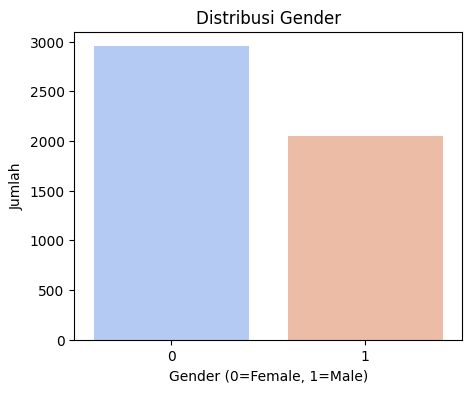

In [10]:
plt.figure(figsize=(5,4))
sns.countplot(x="Male", hue="Male", data=filtered_df, palette="coolwarm", legend=False)
plt.title("Distribusi Gender")
plt.xlabel("Gender (0=Female, 1=Male)")
plt.ylabel("Jumlah")
plt.show()

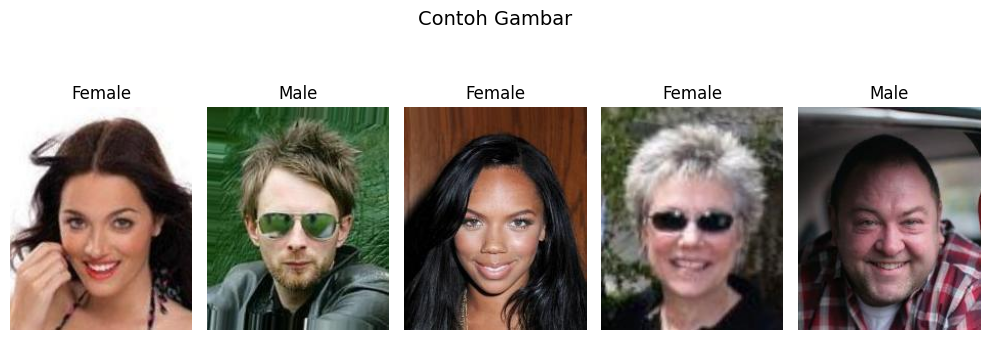

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(10,4))
sample_indices = np.random.choice(filtered_df.index, min(5, len(filtered_df)), replace=False)

for i, idx in enumerate(sample_indices):
    img_path = os.path.join("/content/drive/MyDrive/Colab/FaceRecognition/Images", filtered_df.loc[idx, "filename"])
    img = Image.open(img_path)
    axes[i].imshow(img)
    gender_label = "Male" if filtered_df.loc[idx, "Male"] == 1 else "Female"
    axes[i].set_title(gender_label)
    axes[i].axis("off")

plt.suptitle("Contoh Gambar", fontsize=14)
plt.tight_layout()
plt.show()


DATA SPLIT

In [22]:
train_df, test_df = train_test_split(
    filtered_df, test_size=0.2, stratify=filtered_df["Male"], random_state=42
)
print(f"Train: {len(train_df)}, Test: {len(test_df)}")

Train: 4000, Test: 1000


In [23]:
batch_size = 64
learning_rate = 0.001
epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [24]:
class FaceDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = torch.tensor(int(self.df.iloc[idx, 1]))
        if self.transform:
            image = self.transform(image)
        return image, label

In [25]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [26]:
train_dataset = FaceDataset(train_df[["filename", "Male"]], image_path, transform)
test_dataset = FaceDataset(test_df[["filename", "Male"]], image_path, transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## MODEL

In [27]:
model = models.vgg16(weights="IMAGENET1K_V1")
model.classifier[6] = nn.Linear(4096, 2)

for param in model.features.parameters():
    param.requires_grad = False
for param in model.classifier[-3:].parameters():
    param.requires_grad = True

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# TRAINING

In [28]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
best_acc = 0.0

train_start_time = time.time()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_start_time = time.time()

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    if test_accuracy > best_acc:
        best_acc = test_accuracy
        torch.save(model.state_dict(), "best_vgg16.pth")

    epoch_time = time.time() - epoch_start_time
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Test Loss: {avg_test_loss:.4f} | "
          f"Train Acc: {train_accuracy:.2f}% | "
          f"Test Acc: {test_accuracy:.2f}% | "
          f"Time: {epoch_time:.2f}s")

total_train_time = time.time() - train_start_time
print(f"\nTraining Finished in {total_train_time:.2f} seconds")

model.eval()
with torch.no_grad():
    sample_inputs, _ = next(iter(test_loader))
    sample_inputs = sample_inputs.to(device)
    start_infer = time.time()
    outputs = model(sample_inputs)
    infer_time = time.time() - start_infer

print(f"Inference time for one batch: {infer_time:.4f} seconds")
print(f"Average inference time per image: {infer_time / len(sample_inputs):.6f} seconds/image")

Epoch [1/15] Train Loss: 0.3617 | Test Loss: 0.2748 | Train Acc: 83.45% | Test Acc: 89.20% | Time: 50.47s
Epoch [2/15] Train Loss: 0.2415 | Test Loss: 0.2560 | Train Acc: 89.72% | Test Acc: 89.30% | Time: 44.43s
Epoch [3/15] Train Loss: 0.2303 | Test Loss: 0.2339 | Train Acc: 90.85% | Test Acc: 90.50% | Time: 44.54s
Epoch [4/15] Train Loss: 0.2154 | Test Loss: 0.2295 | Train Acc: 90.78% | Test Acc: 90.20% | Time: 41.18s
Epoch [5/15] Train Loss: 0.1982 | Test Loss: 0.2072 | Train Acc: 91.97% | Test Acc: 91.20% | Time: 44.88s
Epoch [6/15] Train Loss: 0.2001 | Test Loss: 0.2097 | Train Acc: 91.58% | Test Acc: 91.40% | Time: 44.17s
Epoch [7/15] Train Loss: 0.1891 | Test Loss: 0.2109 | Train Acc: 92.05% | Test Acc: 91.00% | Time: 41.37s
Epoch [8/15] Train Loss: 0.1804 | Test Loss: 0.2154 | Train Acc: 92.55% | Test Acc: 91.30% | Time: 40.94s
Epoch [9/15] Train Loss: 0.1678 | Test Loss: 0.1895 | Train Acc: 92.78% | Test Acc: 92.20% | Time: 44.45s
Epoch [10/15] Train Loss: 0.1710 | Test Loss: 

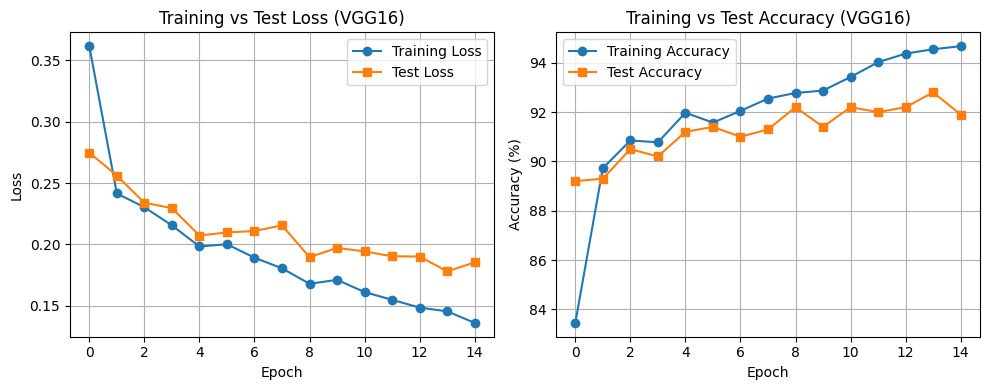

In [29]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Training Loss", marker='o')
plt.plot(test_losses, label="Test Loss", marker='s')
plt.title("Training vs Test Loss (VGG16)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Training Accuracy", marker='o')
plt.plot(test_accuracies, label="Test Accuracy", marker='s')
plt.title("Training vs Test Accuracy (VGG16)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred))


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       591
           1       0.88      0.93      0.91       409

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



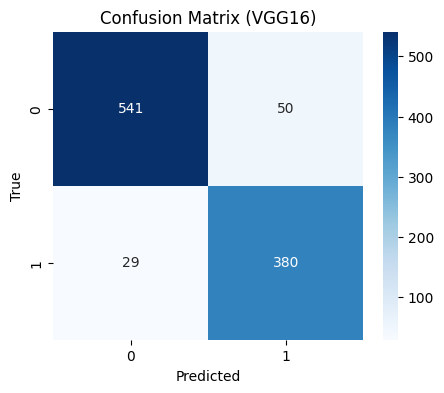

Final Test Accuracy: 92.10%


In [31]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (VGG16)")
plt.show()

accuracy = (np.array(y_true) == np.array(y_pred)).mean() * 100
print(f"Final Test Accuracy: {accuracy:.2f}%")